array([0.  , 0.  , 0.  , 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01])

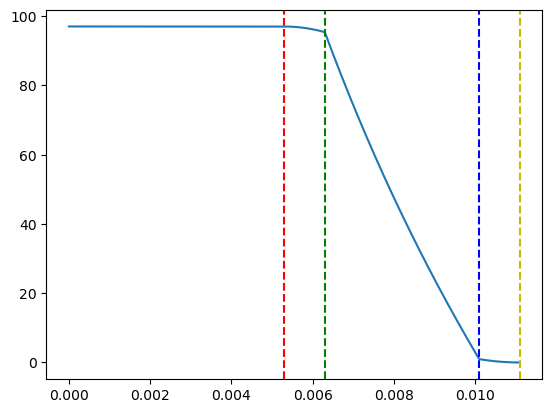

In [4]:
# %%

import numpy as np
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(precision=2, suppress=True)
import scipy.linalg as la
import time
from consts import *
plt.style.use("default")

r1 = consts["r1"]
r2 = consts["r2"]
r3 = consts["r3"]
r4 = consts["r4"]
def find_region(value):
    r1 = consts["r1"]
    r2 = consts["r2"]
    r3 = consts["r3"]
    r4 = consts["r4"]

    # 判断值落在哪个区间
    if 0 <= value < r1: 
        return int(0)
    elif r1 <= value < r2:
        return int(1)
    elif r2 <= value < r3:
        return int(2)
    elif r3 <= value <= r4:
        return int(3)
    else:
        raise ValueError("Value {} is less than 0 or larger than r4".format(value))


class exact_fn():
    def __init__(self,):
        self.name = "RHS"
        self.scale = [0, 1]
        self.mu = 1
        self.mu0 = 1.257*10**-6 # H/m
        self.Jz = -1326291.1924324587
        self.B0 = -0.0001302459397568438
        self.A0 = -0.0006358641469510412

 
    def __call__(self, x):
        # 检查x是否为单个数字，如果是，将其转换为一个元素的数组
        single_value = np.isscalar(x)
        if single_value:
            x = np.array([x])

        result = np.zeros_like(x, dtype=float)
        for i in range(len(x)):
            x_ = x[i]
            region = find_region(x_)
            Param = consts["Params"][region]
            self.A0 = Param["A"]
            self.B0 = Param["B"]
            self.mu = Param["mu"]
            self.Jz = Param["Jz"]
            self.muJz = self.mu * self.mu0 * self.Jz
            if x_ != 0:
                # func1 = A0 - 1/4 * muJz * x_**2 
                func1 = self.A0 + self.B0*np.log(x_) - 1/4 * self.muJz * x_**2 
            else:
                # func1 = A0 + B0*np.log(x_) - 1/4 * muJz * x_**2 
                func1 = self.A0 - 1/4 * self.muJz * x_**2 
            result[i] = func1

        # 如果输入是单个数字，返回单个结果，否则返回数组
        return result[0] * 1e6 if single_value else result * 1e6

    def info(self):
        print("A0:", self.A0, "B0:", self.B0, "mu:", self.mu, "Jz:", self.Jz)
class rhs_fn():
    def __init__(self):
        self.name = "RHS"
        self.scale = [0, 1]
        self.mu = 1
        self.mu0 = 1.257*10**-6 # H/m
        self.Jz = -1326291.1924324587 # A/m^2
        
    def __call__(self, x):
        muJz =  self.Jz
        func1 =  - muJz * x
        return func1 #* 1e6
    # def B(self, x):
        # return x - self.xb
exact_func = exact_fn()
x_data = np.linspace(0, consts["r4"], 5000)
y_data = exact_func(x_data)
plt.plot(x_data, y_data)
# 画出竖线
plt.axvline(x=r1, color='r', linestyle='--', label='r1')  # 红色虚线
plt.axvline(x=r2, color='g', linestyle='--', label='r2')  # 绿色虚线
plt.axvline(x=r3, color='b', linestyle='--', label='r3')  # 蓝色虚线
plt.axvline(x=r4, color='y', linestyle='--', label='r4')  # 黄色虚线

y_data[0]

# np.savez("/Users/xusenqin/Desktop/Advanced-Finite-Element-Methods/FEM_1D_TUe/datasets/Poission.npz", r=x_data, solution=y_data)
def creat_mesh(interfaces = [0, .25, .5, .75, 1], num_elems_per_segment = 3):
    # 初始化网格数组
    mesh = np.array([])

    # 遍历界面列表，为每个子区间生成网格
    for i in range(len(interfaces)-1):
        # 当前子区间的起始点和结束点
        start, end = interfaces[i], interfaces[i+1]

        # 在当前子区间内生成等间距的节点
        # np.linspace包括区间的起始和结束点，但为避免重复添加界面节点，我们从第二个节点开始添加（当i不为0时）
        sub_mesh = np.linspace(start, end, num_elems_per_segment + 1)
        if i > 0:
            sub_mesh = sub_mesh[1:]  # 移除子网格的第一个节点，因为它是上一个子网格的最后一个节点

        # 将子网格添加到总网格中
        mesh = np.concatenate((mesh, sub_mesh))
    return mesh

def define_interfaces(domain):
    
    # 确保domain的起始和结束值都包含在interfaces中
    start, end = domain
    updated_interfaces = [start] + [i for i in interfaces_global if start < i < end] + [end]
    
    return tuple(updated_interfaces)

def find_element_region(mesh_elem):
    interfaces = interfaces_global
    # mesh_elem 是一个包含两个元素的列表，表示当前元素的起始和结束位置
    for i in range(len(interfaces) - 1):
        # 检查当前元素是否位于第 i 个区间内
        if interfaces[i] <= mesh_elem[0] and mesh_elem[1] <= interfaces[i + 1]:
            return i  # 返回当前元素所在的区间索引
    return None  # 如果没有找到符合条件的区间，则返回 None
    
domain = (0.00, 0.0111)
# domain = (0.0101, 0.0111)
# domain = (0, 0.0111)
interfaces = define_interfaces(domain)
# interfaces
mesh = creat_mesh(interfaces = interfaces, num_elems_per_segment = 3)
mesh

(0, 0.0111)
[[  0.5   -0.5    0.     0.     0.     0.     0.     0.     0.  ]
 [ -0.5    2.    -1.5    0.     0.     0.     0.     0.     0.  ]
 [  0.    -1.5   12.6  -11.1    0.     0.     0.     0.     0.  ]
 [  0.     0.   -11.1   23.2  -12.1    0.     0.     0.     0.  ]
 [  0.     0.     0.   -12.1   12.48  -0.38   0.     0.     0.  ]
 [  0.     0.     0.     0.    -0.38   0.86  -0.48   0.     0.  ]
 [  0.     0.     0.     0.     0.    -0.48  21.18 -20.7    0.  ]
 [  0.     0.     0.     0.     0.     0.   -20.7   42.4  -21.7 ]
 [  0.     0.     0.     0.     0.     0.     0.     0.     1.  ]]
-----------------------
 [ 0.    0.   -3.75 -7.96 -4.21  0.    3.85  7.96  0.  ]


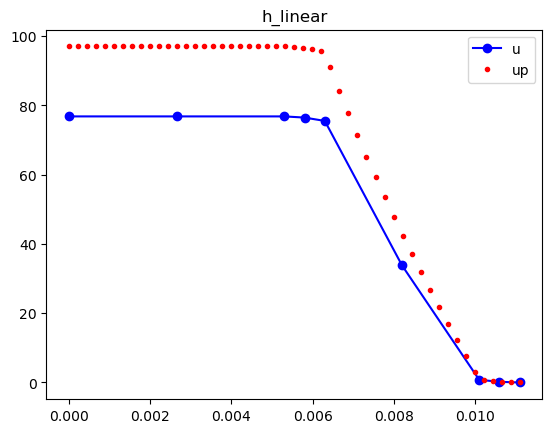

[20.19259591729623, 20.19259591729623, 20.192595917296458, 20.111959310299227, 19.868536907477704, 8.845978470338139, 0.20225399317034454, 0.05045941558086631, 8.131516293641283e-14]
76.83541105644792


In [8]:

def fem1d_linear(f, d2f, domain=(0, 0.0111), BCs = (0, 1), num_elems_per_segment =3):
    #
    #  Define the mesh, N+1 points between A and B.
    #  These will be X[0] through X[N].
    #
    print(domain)
    a = domain[0]
    b = domain[-1]

    interfaces = define_interfaces(domain)
    mesh = creat_mesh(interfaces = interfaces, num_elems_per_segment = num_elems_per_segment )
    x = mesh
    # x = np.linspace(a, b, n + 1)
    n = len(mesh)-1
#
#  Set a 3 point quadrature rule on the reference interval [-1,1].
#
    q_num = 3

    xg = np.array((
    -0.774596669241483377035853079956,
    0.0,
    0.774596669241483377035853079956))

    wg = np.array((
        5.0 / 9.0,
        8.0 / 9.0,
        5.0 / 9.0))

    A = np.zeros((n + 1, n + 1))
    rhs = np.zeros(n + 1)

    for e in range(0, n):

        xl = x[e]
        xr = x[e+1]
        scale = [xl, xr]
        region_index = find_element_region(scale)
        Param = consts["Params"][region_index]
        mu = Param["mu"]
        Jz = Param["Jz"]
        d2f.mu = mu
        d2f.Jz = Jz
        scale_up = (xr-xl) / 2
        # print(scale_up)

        for q in range(0, q_num):
            xq = ((1.0 - xg[q]) * xl + (1.0 + xg[q]) * xr) / 2.0
            wq = wg[q] * (xr - xl) / 2.0

            for i_local in range(0, 2):
                i = i_local + e

                if (i_local == 0):
                    phii = (xq - xr) / (xl - xr)
                    phiip = 1 / (xl - xr)
                else:
                    phii = (xq - xl) / (xr - xl)
                    phiip = 1 / (xr - xl)

                rhs[i] = rhs[i] + wq * phii * d2f(xq) #* scale_up **2
                for j_local in range(0, 2):
                    j = j_local + e

                    if (j_local == 0):
                        phijp = 1 / (xl - xr)
                    else:
                        phijp = 1 / (xr - xl)

                    # A[i][j] = A[i][j] +  xg[q] * wq * phiip * phijp
                    A[i][j] = A[i][j] + wq * phiip * phijp * xq /mu #* scale_up

    # A[0, 0] = 1.0
    # A[0, 1:n+1] = 0.0
    # rhs[0] = f(x[0])
    # print(rhs)
    A[-1, -1] = 1.0
    A[-1, 0:-1] = 0.0
    rhs[-1] = BCs[-1]

    print(A)
    # print(rhs)
    print('-----------------------\n', rhs)
    u = la.solve(A, -rhs)

    uex = np.zeros(n + 1)
    for i in range(0, n + 1):
        uex[i] = f(x[i])
    err = []
    for i in range(0, n + 1):
        err.append(abs(uex[i] - u[i]))

    npp = 51
    xp = np.linspace(a, b, npp)
    up = np.zeros(npp)
    for i in range(0, npp):
        up[i] = f(xp[i])

    # plt.plot(x, u, 'bo-', xp, up, 'r.')
    filename = 'fem1d.png'
    plt.savefig(filename)
    # plt.show()

    # plt.figure()
    plt.plot(x, u, 'bo-', label='u')
    plt.plot(xp, up, 'r.', label='up')
    plt.title('h_linear')
    plt.legend()
    plt.show()
    # print(xp)

    return err, u, up


if __name__ == '__main__':
    # for i in [6, 11, 21, 41]:
    #     err, u, up = fem1d_linear(exact_fn, rhs_fn, i)
    domain = (0, 0.0111)
    
    exact_func = exact_fn()
    rhs_func = rhs_fn()
    BCs = (exact_func(domain[0]), exact_func(domain[-1]))
    err, u, up = fem1d_linear(exact_func, rhs_func,BCs = BCs, num_elems_per_segment =2)
    # print(err)
    print(u[0])
    # plt.plot(err)
# %%


